In [9]:
import pandas as pd
import numpy as np
import pylab as plt

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import r2_score
from sklearn.preprocessing import RobustScaler, scale
from scipy.stats import multivariate_normal
from scipy.io import loadmat
from mne.decoding.receptive_field import _delay_time_series

from tqdm import tqdm
import mne

rng = np.random.RandomState(1337) 
%matplotlib inline

# Regression with two variables: direction matters
Show that the regression solution differs when you do $y=wx$ vs. $x=wy$

In [10]:
n = 500
noise_amt = 2

a = rng.randn(n)
weight = 2
b = weight * a + rng.randn(n) * noise_amt

[(-9.33372461337489, 10.383805624862866)]

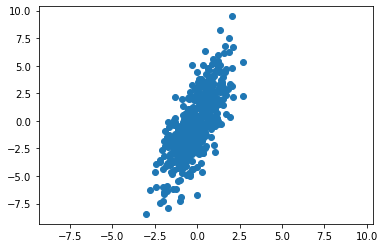

In [11]:
fig, ax = plt.subplots()
ax.plot(a, b, 'o')
ax.set(xlim=ax.get_ylim())

[(-9.499126573880169, 10.391681908696452)]

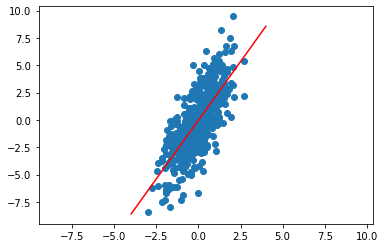

In [12]:
test_pts_b = np.linspace(-4, 4, 1000)[:, np.newaxis]

mod = LinearRegression()
mod.fit(a[:, np.newaxis], b)
preds_b = mod.predict(test_pts_b)

fig, ax = plt.subplots()
ax.plot(a, b, 'o')


ax.plot(test_pts_b, preds_b, 'r-')
ax.set(xlim=ax.get_ylim())

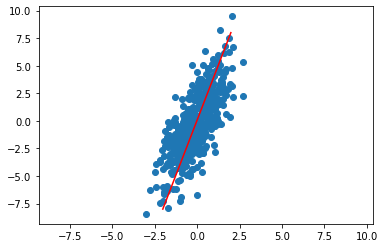

In [13]:
test_pts_a = np.linspace(-8, 8, 1000)[:, np.newaxis]

mod = LinearRegression()
mod.fit(b[:, np.newaxis], a)
preds_a = mod.predict(test_pts_a)

fig, ax = plt.subplots()
ax.plot(a, b, 'o')

ax.plot(preds_a, test_pts_a, 'r-')
_ = ax.set(xlim=ax.get_ylim())

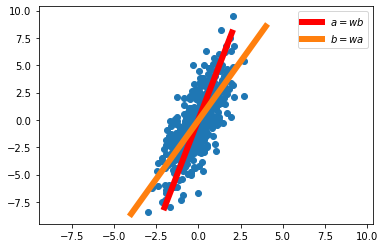

In [14]:
kwargs = dict(lw=6)
fig, ax = plt.subplots()
ax.plot(a, b, 'o')
ln1 = ax.plot(preds_a, test_pts_a, 'r-', **kwargs)
ln2 = ax.plot(test_pts_b, preds_b, '-', **kwargs)
_ = ax.set(xlim=ax.get_ylim())
ax.legend(ax.lines[1:], ['$a=wb$', '$b=wa$'])

# Now with real data
We'll use natural speech along with an artificial STRF to simulate an artifical electrode's response to the speech. Then we'll attempt to uncover the STRF using both encoding and decoding methods

In [15]:
# Load the data file and the sampling frequency we'll use
path_speech = mne.datasets.mtrf.data_path()
speech = mne.read_epochs('../features/spectrogram-epo.fif')
len_epoch = len(speech.times)
sfreq = speech.info['sfreq']
freqs = np.array(speech.ch_names).astype(float)

# Downsample the data etc so that fitting is faster
msk_freqs = freqs < 5000.
msk_freqs[::2] = 0
freqs = freqs[msk_freqs]
speech = np.hstack(speech._data)[msk_freqs]
speech = RobustScaler().fit_transform(np.log(speech).T).T
n_freqs = len(freqs)

# This is how much we'll decimate data to speed things up
n_decim = 2
sfreq /= n_decim

Reading ../features/spectrogram-epo.fif ...


FileNotFoundError: [Errno 2] No such file or directory: '../features/spectrogram-epo.fif'

## Simulating the receptive field

In [ ]:
# Create time delays
tmin, tmax = -.4, 0.
delays_samp = np.arange(np.round(tmin * sfreq),
                        np.round(tmax * sfreq) + 1).astype(int)
delays_sec = delays_samp / sfreq

In [ ]:
# Simulate the RF with a grid of all possible freqs / delays
grid = np.array(np.meshgrid(delays_sec, freqs))

# We need data to be shaped as n_features, n_times, so swap axes here
grid = np.rollaxis(grid, 0, 3)

# Simulate a temporal receptive field with a Gabor filter
means_high = [-.1, 1000]
means_low = [-.15, 2000]
cov = [[.0005, 0], [0, 200000]]
gauss_high = multivariate_normal.pdf(grid, means_high, cov)
gauss_low = -1 * multivariate_normal.pdf(grid, means_low, cov)
weights = gauss_high + gauss_low  # Combine to create the "true" STRF

In [ ]:
# Visualize
kwargs = dict(vmax=np.abs(weights).max(), vmin=-np.abs(weights).max(),
              cmap='RdBu_r')
fig, ax = plt.subplots()
ax.pcolormesh(delays_sec, freqs, weights, **kwargs)
ax.set(title='Simulated STRF', xlabel='Time Lags (s)', ylabel='Frequency (Hz)')
plt.setp(ax.get_xticklabels(), rotation=45)
plt.autoscale(tight=True)
mne.viz.tight_layout()

## Creating out speech stimuli
Here we'll create two kinds of speech stimuli we can use to fit a model.

### Natural speech
First we'll use an input stimulus consisting of natural speech. Is important because natural speech has structure that the brain is tuned to. However, because of this structure it can also throw off predictive modeling as we will see.

In [ ]:
# Read in speech that's been recorded
speech = mne.filter.resample(speech, down=n_decim, npad='auto')

### White noise
White noise is a common stimulus used in receptive field modeling of single units. This is because white noise is decorrelated across spectral frequencies and time lags. This gives the model nice properties, at the cost of being a (highly) unnatural stimulus. It is generally used to study earlier parts of the auditory pathway, with the assumption that these parts do not care about higher-level structure in sounds.

In [ ]:
# We can simply create random noise to simulate this stimulus
white_noise = np.random.randn(*speech.shape)
white_noise *= speech.mean()

## Simulating a neural response

Using this receptive field and the audio we created above, we'll create an artificial neural response to the stimulus.

In [ ]:
# We'll use a function for this so that we can repeat easily
def simulate_response(X, noise_amp=1):
    # Delay the spectrogram according to delays so it can be combined w/ the STRF
    n_times = X.shape[-1]
    X_del = _delay_time_series(X, tmin, tmax, sfreq, newaxis=1, axis=-1)
    X_del = X_del[:, ::-1, :]
    X_del = X_del.reshape([-1, n_times])
    weights_sim = weights.ravel()
    
    # Simulate a neural response to the sound, given this STRF
    y = np.dot(weights_sim, X_del) + noise_amp * rng.randn(n_times)
    return X_del, y

def plot_model_features(X, y, label=None):
    # Plot a sample of speech and the simulated electrode activity
    X_plt = scale(X.T).T
    y_plt = scale(y)
    time = np.arange(X_plt.shape[-1]) / sfreq

    fig, axs = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
    axs[0].pcolormesh(
        time, freqs, X_plt[:len(delays_samp) * n_freqs:len(delays_samp)],
        vmin=0, vmax=4, cmap='viridis')
    s = 'Input auditory features'
    if label is not None:
        s += ': {}'.format(label)
    axs[0].set_title(s)
    axs[0].set(ylim=[freqs.min(), freqs.max()], ylabel='Frequency (Hz)')
    axs[1].plot(time, y_plt)
    axs[1].set(xlim=[time.min(), time.max()], title='Simulated response',
               xlabel='Time (s)', ylabel='Activity (a.u.)')
    mne.viz.tight_layout()
    return fig

In [ ]:
# Simulate the neural response to this input, given a STRF
noise_amp = .01
X, y = simulate_response(speech, noise_amp=noise_amp)
n_features = X.shape[0]

# Show the kinds of features we're putting into our model
_ = plot_model_features(X[:, :600], y[:600])

## Recovering the STRF with an encoding model

In [ ]:
mod = Ridge(alpha=1e1)
mod.fit(X.T, y.T)
coefs_encoding = mod.coef_.reshape((n_freqs, len(delays_samp)))
fig, ax = plt.subplots(figsize=(4, 4))
ax.pcolormesh(delays_sec, freqs, coefs_encoding, **kwargs)

## Recovering the STRF with a decoding model

Here we'll take advantage of the fact that scikit-learn allows you to fit multiple models with one call to `fit` by including extra columns in the output matrix.

In [ ]:
# Loop through each spectrogram frequency band / time lag, fit a model for each
mod.fit(y[:, np.newaxis], X.T)
coefs_decoding = mod.coef_.squeeze().reshape((n_freqs, len(delays_samp)))

In [ ]:
# Now we'll compare both
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5),
                               sharex=True, sharey=True)
ax1.pcolormesh(delays_sec, freqs, coefs_encoding, **kwargs)
ax1.set(title='Encoding Model Coefficients')
ax2.pcolormesh(delays_sec, freqs, coefs_decoding, cmap=plt.cm.RdBu_r)
ax2.set(title='Decoding Model Coefficients')

_ = plt.setp([ax1, ax2], xlabel='Time lag (s)', ylabel='Frequency (Hz)')

As you can see, in a decoding model the receptive field is smeared across both time and frequency. This is because of the (many) correlations that exist between these features. When fitting an encoding model, the regression and regularization account for these correlations. However in a decoding approach, each model is fit independently, and artificial feature correlations are introduced.

## Using white noise
Let's see what happens when we use white noise to fit the model. White noise does not contain correlations between time and frequency.

We'll do the same plotting / fitting procedure above for both natural speech and white noise so that it's easy to compare.

In [ ]:
for audio, label in [(speech, 'speech'), (white_noise, 'white noise')]:
    # Simulate the neural response to this input, given a STRF
    X, y = simulate_response(audio, noise_amp=noise_amp)
    n_features = X.shape[0]

    # Show the kinds of features we're putting into our model
    _ = plot_model_features(X[:, :600], y[:600], label)
    
    # Fit an encoding model
    mod = Ridge(alpha=1e1)
    mod.fit(X.T, y.T)
    coefs_encoding = mod.coef_.reshape((n_freqs, len(delays_samp)))
    
    # Fit a decoding model
    mod.fit(y[:, np.newaxis], X.T)
    coefs_decoding = mod.coef_.reshape((n_freqs, len(delays_samp)))
    cov
    
    # Plot the comparison
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5),
                               sharex=True, sharey=True)
    ax1.pcolormesh(delays_sec, freqs, coefs_encoding, **kwargs)
    ax1.set(title='Encoding Model Coefficients\n{}'.format(label))
    ax2.pcolormesh(delays_sec, freqs, coefs_decoding, cmap=plt.cm.RdBu_r)
    ax2.set(title='Decoding Model Coefficients\n{}'.format(label))

    _ = plt.setp([ax1, ax2], xlabel='Time lag (s)', ylabel='Frequency (Hz)')


As you can see, using white noise means that the end result is roughly the same in either decoding or encoding. This is because there are no correlations between the stimulus features, and thus the result does not depend on their covariance matrix ($X^TX$). Unfortunately, it also means that the stimuli are unrepresentative of what we hear in the natural world. 

We urge you to use caution when using decoding models to describe the neural response to stimulus features, and to consider the extent to which stimulus properties (such as correlations) are not being accounted for by the model.

# Calculating an upper bound on model performance
This is also a useful moment to talk about signal-to-noise ratios, and how this affects our ability to gauge the "quality" of a model. Given a model score, this may either be good or bad depending on the *maximum possible score* that we'd expect given the noisiness in the data. In this way, one can report the score as a percentage of the maximum possible value.

According to [1], it is possible to calculate an upper bound on model performance using multiple repetitions of the same stimulus. This process works by first splitting the response to repetitions of the stimulus into two groups. The mean of each group is calculated, and then the coefficient of determination ($R^2$) or the coherence ($\gamma^2$) is calculated between them.

This process is then repeated many times, resulting in the value $R^2_{\bar{R}_{1,M/2}\bar{R}_{2,M/2}}$, which represents the average (over many repeats of the above process). This is then inserted into the following equation:

$$\frac{1}{R^2_{AR}} - 1 = \frac{1}{2} \Bigg(-M + M\sqrt{\frac{1}{R^2_{\bar{R}_{1,M/2}\bar{R}_{2,M/2}}}}\Bigg)$$

Where $M$ represents the number of repetitions of the stimulus in question.

Below, we'll simulate multiple repetitions to the same stimulus, and see how this affects the expected value of $R^2$.

First, we'll simulate the data. We can use varying levels of noise amplitude to see how this affects the resulting signal (and the estimate of maximum model score).

[1] https://www.ncbi.nlm.nih.gov/pubmed/15214701

In [ ]:
from sklearn.model_selection import ShuffleSplit

# Simulate the neural response to this input, given a STRF
noise_amp = 1
X, y = simulate_response(speech, noise_amp=noise_amp)
n_features = X.shape[0]

# Show a single input / response
_ = plot_model_features(X[:, :600], y[:600])

# Now do this many times
# This represents the same stimulus being presented multiple times
n_trials = 40
repetitions = []
for _ in tqdm(range(n_trials)):
    repetitions.append(simulate_response(speech, noise_amp)[1])
repetitions = np.array(repetitions)

Now we will perform the process of estimating the model score ceiling (the noise ceiling). We'll split the data into two random groups, calculate each group's mean, then calculate the statistic of interest between them. We'll then repeat this many times.

In [ ]:
n_iterations = 20
splitter = ShuffleSplit(n_iterations, test_size=.5)

scores = np.zeros(n_iterations)
means = []
for ii, (ix1, ix2) in enumerate(splitter.split(repetitions)):
    grp1 = repetitions[ix1].mean(0)
    grp2 = repetitions[ix2].mean(0)
    scores[ii] = r2_score(grp1, grp2)
    means.append((grp1, grp2))
means = np.array(means)

Now, we'll calculate the expected model score given the equation above.

In [ ]:
def calculate_upper_bound(similarity, n_epochs):
    """Calculate an upper bound on model performance.

    Parameters
    ----------
    similarity : array, any shape
        The estimated similarity across epochs. This
        is either the R^2 or coherence between means of subsets of
        trials for one electrode.
    n_epochs : int
        The number of epochs used in the coherence estimation

    Returns
    -------
    upper_bound : array, shape == similarity.shape
        The upper bound on model performance as estimated by coherence across
        trials. This is either the expected coherence or expected correlation,
        depending on which type of input is given in similarity.
    """
    right_hand = .5 * (-n_epochs + n_epochs * np.sqrt(1. / similarity))
    upper_bound = 1. / (right_hand + 1)
    return upper_bound

# Now, calculate the upper bound and report it below
upper_bound = calculate_upper_bound(np.mean(scores), n_trials)

The upper bound is meant to reflect the stability of the signal across multiple repetitions, compared with the signal in a single repetition. Below we'll visualize each.

In [ ]:
# Now we'll visualize what the calculated mean in each group looks like
fig, axs = plt.subplots(2, 1, figsize=(10, 10), sharex=True, sharey=True)
kwargs = dict(alpha=.1, color='k')

for irepetition in repetitions[:10]:
    axs[0].plot(irepetition[:800], **kwargs)

for irepetition in means[:10]:
    axs[1].plot(irepetition[0, :800], **kwargs)
fig.suptitle('Estimated upper bound on $R^2$: {:.3f}'.format(upper_bound),
             fontsize=18)
axs[0].set_title('Single trial repetitions', fontsize=16)
axs[1].set_title('Group means of random subsets', fontsize=16)

As you can see above, there is much more variability on the individual trial level, and a much more consistent response when we look at averages across many trials.